In [1]:
import cv2
import tempfile, os
from general_utils.model.yolo.yolo_predictor import YoloPredictor
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import tempfile
from random import randint
import math
import pandas as pd
from operator import itemgetter
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

# leyendo dataset

In [2]:
def random_color():
    r = randint(0, 255)
    g = randint(0, 255)
    b = randint(0, 255)    
    return (r, g, b)

def xml2list(xml_path):
    #print("xml to csv {}".format(xml_path))
    xml_list = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for member in root.findall('object'):
            tag = str(member.findall('name')[0].text)
            xmin = int(member.findall('bndbox')[0].findall('xmin')[0].text)
            ymin = int(member.findall('bndbox')[0].findall('ymin')[0].text)
            xmax = int(member.findall('bndbox')[0].findall('xmax')[0].text)
            ymax = int(member.findall('bndbox')[0].findall('ymax')[0].text)

            xml_list.append({
                tag: (xmin, ymin, xmax, ymax)
            })      
    except Exception as e:
        print('xml conversion failed:{}'.format(e))
    return xml_list

In [3]:
TIME_PROPOSE = 1 # second

In [4]:
DATASET = "Tailandia"
# serverstorage/Almacenamiento I+D+i/Proyectos/04.01.02 Proyectos en Curso/IA/20220927 FD-Image/20221111 Tracking-Vehicles/data/Tailandia/Tailandia
FOLDER = "/serverstorage/Tailandia"

In [5]:
DATASET = "PlaceSpain"
# serverstorage/Almacenamiento I+D+i/Proyectos/04.01.02 Proyectos en Curso/IA/20220927 FD-Image/20221111 Tracking-Vehicles/data/Plaza de España/Frames
FOLDER = "/serverstorage/Cibeles"

In [6]:
DATASET = "Demo"
# serverstorage/Almacenamiento I+D+i/Proyectos/04.01.02 Proyectos en Curso/IA/20220927 FD-Image/20221111 Tracking-Vehicles/data/8/2023-03-24 10-02-19
FOLDER = "/serverstorage/2023-03-24 10-02-19"

In [7]:
images = []
xml = []
for file in os.listdir(FOLDER):
    name, extension = file.split(".")
    if extension.find("xml")>=0:
        xml.append(name)
    else:
        images.append(file)

images.sort()

images[:5], xml[:5]

(['2023-03-24 10-02-19 001.jpg',
  '2023-03-24 10-02-19 002.jpg',
  '2023-03-24 10-02-19 003.jpg',
  '2023-03-24 10-02-19 004.jpg',
  '2023-03-24 10-02-19 005.jpg'],
 ['2023-03-24 10-02-19 121',
  '2023-03-24 10-02-19 152',
  '2023-03-24 10-02-19 039',
  '2023-03-24 10-02-19 032',
  '2023-03-24 10-02-19 118'])

In [8]:
len(images), len(xml)

(157, 120)

# leyendo las imagenes y cargandolas en memoria

In [9]:
all_images = []
all_names = []
vehicles = {}

### usando el dataset de "/serverstorage/Tailandia"

In [15]:
sizes_images = []

for i, image in enumerate(images):

    image = os.path.join(FOLDER, image)
    file, extension = image.split(".")

    image = cv2.imread(image)    
    
    tags = None
    try:  
        xml_to_search = file.split(os.sep)[-1]
        id_xml = xml.index(xml_to_search)   
        file_xml = os.path.join(FOLDER, xml[id_xml]+".xml")
        tags = xml2list(file_xml)   
    except Exception as e:        
        pass

    if tags:
        shape = '-'.join(str(e) for e in  list(image.shape))
        if shape not in sizes_images:
            sizes_images.append(shape)
            
        for tag in tags:
            for k, (xmin, ymin, xmax, ymax) in tag.items():     
                file_xml = file.split(os.sep)[-1]
                try:
                    time_frame = int(file_xml.split(" ")[-1])
                    pass
                except:
                    time_frame = int(file_xml.split("ing")[-1])
                    pass

                if time_frame:
                    tmp = k.split("_")
                    name_vehicle, type_vehicle = tmp[0], tmp[1]
                    #print(name_vehicle, type_vehicle, time_frame)
    
                    color = (255, 0, 0)  # Blue color in BGR                
                    thickness = 2  # Line thickness of 2 px
                    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
        
                    center_coordinates = xmin + int((xmax-xmin)/2), ymin + int((ymax-ymin)/2)
                    radius = 20
                    color = (0, 0, 255)
                    thickness = 2
                    image = cv2.circle(image, center_coordinates, radius, color, thickness)
        
                    fontScale = 1
                    color = (255, 0, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, name_vehicle, (xmin, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    fontScale = 1
                    color = (0, 0, 255)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, str(time_frame), (xmax, ymax), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    fontScale = 1
                    color = (0, 255, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, str(type_vehicle), (xmax, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
    
                    bbox_area = ( xmax - xmin ) * ( ymax - ymin )
    
                    if name_vehicle not in vehicles:
                        vehicles[name_vehicle] = []
                        all_names.append(name_vehicle)
    
                    vehicles[name_vehicle].append(
                        {
                            "center": center_coordinates,
                            "area": bbox_area,
                            "frame_id": i,
                            "shape": image.shape,
                            "cam": 0,
                            "type_vehicle": type_vehicle,
                            "time": time_frame,
                            "file": file
                        }
                    )
        
                    all_names.append(name_vehicle)
    all_images.append(image)
    #break


height,width,layers = all_images[0].shape
height,width, sizes_images

(1080, 1920, ['1080-1920-3'])

In [16]:
len(all_names), len(vehicles)

(617, 31)

### usando el dataset de "/serverstorage/2023-03-24 10-02-19"

In [17]:
conteo = 0
CAM_FILTER = "01"

for i, image in enumerate(images):

    image = os.path.join(FOLDER, image)
    file, extension = image.split(".")
    
    image = cv2.imread(image)    
    tags = None
    try:  
        xml_to_search = file.split(os.sep)[-1]
        id_xml = xml.index(xml_to_search)   
        file_xml = os.path.join(FOLDER, xml[id_xml]+".xml")
        tags = xml2list(file_xml)   
    except Exception as e:        
        pass

    if tags:
        #print("SI:", i)
        for tag in tags:
            for k, (xmin, ymin, xmax, ymax) in tag.items():
                name_key = k.split("_")[0]
                name_cam = k.split("_")[1]

                if CAM_FILTER == name_cam:
                
                    color = (255, 0, 0)  # Blue color in BGR                
                    thickness = 2  # Line thickness of 2 px
                    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
        
                    center_coordinates = xmin + int((xmax-xmin)/2), ymin + int((ymax-ymin)/2)
                    radius = 20
                    color = (0, 0, 255)
                    thickness = 2
                    image = cv2.circle(image, center_coordinates, radius, color, thickness)
        
                    fontScale = 1
                    color = (255, 0, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, name_key, (xmin, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    bbox_area = ( xmax - xmin ) * ( ymax - ymin )
        
                    if name_key not in vehicles:
                        vehicles[name_key] = []
                        all_names.append(name_key)
                        
                    vehicles[name_key].append(
                        {
                            "center": center_coordinates,
                            "area": bbox_area,
                            "frame_id": i,
                            "cam": name_cam,
                            "file": file
                        }
                    )
        
                    all_names.append(name_key)
    else:
        #print("NO:", i)
        pass

    all_images.append(image)

height,width,layers=all_images[1].shape

# Analizando el compilado de las imagenes

## export complete video

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

In [10]:
video = cv2.VideoWriter(f"/serverstorage/{DATASET}.avi", fourcc, 1, (width,height))

for i, image in enumerate(all_images):
    video.write(image)
    
cv2.destroyAllWindows()
video.release()

## export video for specific car

In [ ]:
name_car = all_names[0]

name_car, vehicles[name_car]

In [ ]:

newlist = sorted(vehicles[name_car], key=itemgetter('frame_id')) 

video = cv2.VideoWriter(f"/serverstorage/{name_car}.avi", fourcc, 1, (width,height))
for d in newlist:
    id = d['frame_id']
    image = all_images[id]
    video.write(image)
    
cv2.destroyAllWindows()
video.release()

name_car

## ver movimientos segun tipo

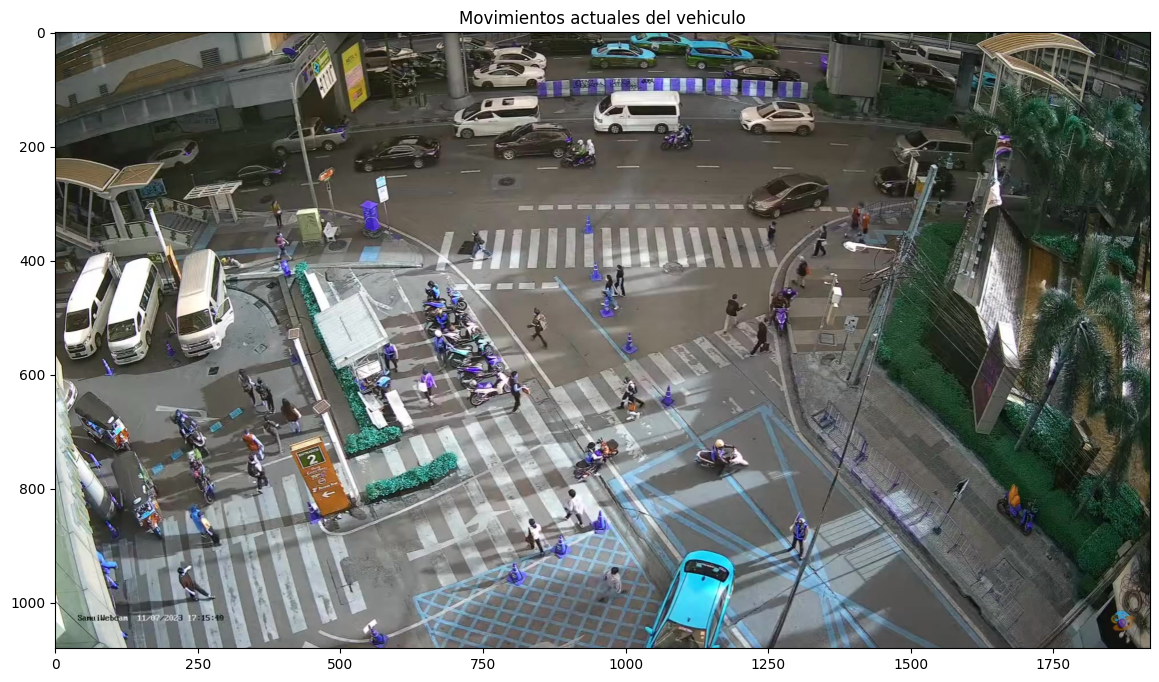

In [18]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)

plt.figure(figsize=(20,8))
plt.title('Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

In [34]:
vehicles["0001"]
#[ id["type_vehicle"] for id in vehicles["0001"] ]

[{'center': (1296, 192),
  'area': 1440,
  'frame_id': 10,
  'shape': (1080, 1920, 3),
  'cam': 0,
  'type_vehicle': '01',
  'time': 11,
  'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 011'},
 {'center': (1271, 215),
  'area': 1920,
  'frame_id': 11,
  'shape': (1080, 1920, 3),
  'cam': 0,
  'type_vehicle': '01',
  'time': 12,
  'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 012'},
 {'center': (1268, 215),
  'area': 2226,
  'frame_id': 12,
  'shape': (1080, 1920, 3),
  'cam': 0,
  'type_vehicle': '01',
  'time': 13,
  'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 013'},
 {'center': (1296, 192),
  'area': 1440,
  'frame_id': 10,
  'shape': (1080, 1920, 3),
  'cam': 0,
  'type_vehicle': '01',
  'time': 11,
  'file': '/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 011'},
 {'center': (1271, 215),
  'area': 1920,
  'frame_id': 11,
  'shape': (1080, 1920, 3),
  'cam': 0,
  'type_vehicle': '01',
  'time': 12,
  'file': '/serverstora

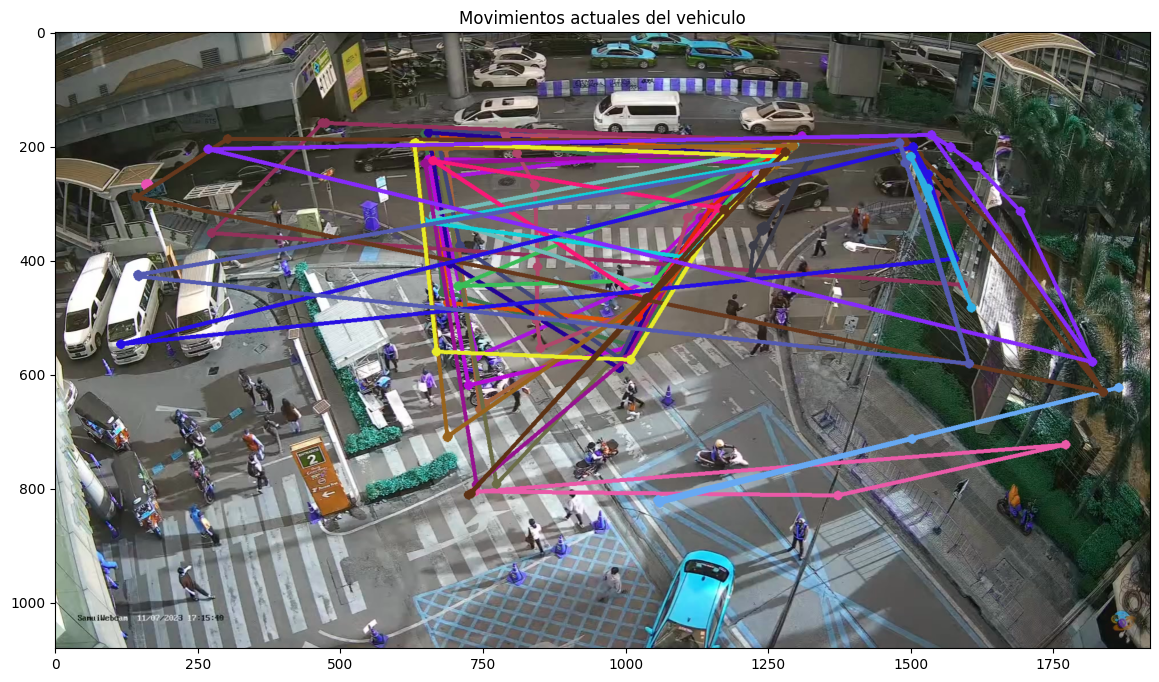

In [36]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

for name_car in all_names:
    
    color = random_color()
    
    #print(name_car)

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    
    type_vehicle = []
    for id in vehicles[name_car]:
        try:
            type_vehicle.append(id["type_vehicle"])
        except:
            pass
    
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        desde = coordinate
        hasta = coordinates[i+1]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

In [38]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

type_vehicle_graph = "01"

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = []
    for id in vehicles[name_car]:
        try:
            type_vehicle.append(id["type_vehicle"])
        except:
            pass
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        if type_vehicle[i] == type_vehicle_graph:
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        if type_vehicle[i] == type_vehicle_graph:
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo {type_vehicle_graph}')
plt.imshow(fondo)
plt.show()

IndexError: list index out of range

In [21]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

type_vehicle_graph = "05"

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = [ id["type_vehicle"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        if type_vehicle[i] == type_vehicle_graph:
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        if type_vehicle[i] == type_vehicle_graph:
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo {type_vehicle_graph}')
plt.imshow(fondo)
plt.show()

KeyError: 'type_vehicle'

# prediciendo la proxima posicion del vehiculo de acuerdo a su trayectoria

In [ ]:
def hallar_valor_futuro(original_data):
    (p, d, q) = (1, 1, 2)
    
    if len(original_data) > 2: 
        all_x = []
        all_y = []
        for x, y in original_data:
            all_x.append(x)
            all_y.append(y)
        
        
        model_x = ARIMA(all_x, order=(p, d, q))
        model_y = ARIMA(all_y, order=(p, d, q))
        
        model_x_fit = model_x.fit()
        model_y_fit = model_y.fit()
        
        future_steps = 2  # Número de pasos futuros para predecir
        forecast_x = model_x_fit.get_forecast(steps=future_steps)
        forecast_y = model_y_fit.get_forecast(steps=future_steps)
        
        # Obtener los valores predichos y los intervalos de confianza
        predicted_values_x = forecast_x.predicted_mean
        confidence_intervals_x = forecast_x.conf_int()
        
        predicted_values_y = forecast_y.predicted_mean
        confidence_intervals_y = forecast_y.conf_int()
        
        predicted_values_x = [ int(a) for a in  list(predicted_values_x)]
        predicted_values_y = [ int(a) for a in  list(predicted_values_y)]
        
        
        predictions = list(zip(list(predicted_values_x), list(predicted_values_y)))
        
        #list(zip(all_x, all_y))
        return predictions
    print("NO hay suficientes datos para hallar un valor futuro")

In [ ]:
estado = ["O", "P"]

def graficar_original_prediccion(original_data, predictions, ax = None, plot=True, fondo=None):

    if fondo is None:
        fondo = 255*np.ones([height, width, 3], np.uint8)
    else:
        fondo = cv2.imread(fondo)
        #fondo = cv2.cvtColor(fondo, cv2.COLOR_BGR2GRAY)
        #fondo = mpimg.imread(fondo)
    
    radius = 5
    thickness = 5
    
    for k, coordinates in enumerate([
        original_data ,
        predictions
    ]):
        if coordinates:
            color = random_color()
            for i, coordinate in enumerate(coordinates):
                fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
            
            for i, coordinate in enumerate(coordinates[:-1]):
                # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
                desde = coordinate
                hasta = coordinates[i+1]
                fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
            fontScale = 1
            font = cv2.FONT_HERSHEY_SIMPLEX
            fondo = cv2.putText(fondo, estado[k], coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
    
    if predictions:
        # unir original y prediccion en el grafico
        desde = original_data[-1]
        hasta = predictions[0]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
    if not ax:
        plt.figure(figsize=(20,8))
        plt.title('Movimientos actuales del vehiculo')
        #plt.axis("off")
        fondo = fondo[:, int(width/2):]
        plt.imshow(fondo)
    else:
        fondo = fondo[:, int(width/2):]
        ax.imshow(fondo)
    
    if plot:
        plt.show()

In [ ]:
nombres = all_names
nombres = list(set(all_names))
len(nombres)

In [ ]:
## ver data

In [ ]:
directions = {
    "up": 0, 
    "down": 1,
}

fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

all_center = []
all_areas = []
all_directions = []
all_distance = []

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = vehicles[name_car]["type_vehicle"]
    # order first position 1 and after by postiion 0
    #coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 

    if type_vehicle == "01":

        area = [ id["area"] for id in vehicles[name_car] ]
        
        for i, coordinate in enumerate(coordinates):
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
            all_center.append(coordinate)
            all_areas.append(area[i])
    
        for i, coordinate in enumerate(coordinates[:-1]):
            # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
            distance = np.sqrt((hasta[0]-desde[0])**2 + (hasta[1]-desde[1])**2)
            all_distance.append(distance)
            
            #angle = math.atan2(y, x) * (180.0 / math.pi)
        
    
        direction = directions["up"]
    
        fontScale = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        #fondo = cv2.putText(fondo, str(direction), coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
        
        for _ in coordinates:
            all_directions.append(direction)
        #break

plt.figure(figsize=(20,8))
plt.title('Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

cv2.imwrite("/serverstorage/Movimientos_actuales_del_vehiculo.jpg", fondo)

coordinates_noOrder

In [ ]:
def graficar_original_prediccion2(data_end, ax = None, plot=True, fondo=None):

    if fondo is None:
        fondo = 255*np.ones([height, width, 3], np.uint8)
    else:
        fondo = cv2.imread(fondo)
        #fondo = cv2.cvtColor(fondo, cv2.COLOR_BGR2GRAY)
        #fondo = mpimg.imread(fondo)
    
    radius = 5
    thickness = 5
    
    for k, estado in enumerate([
        i for i in data_end.keys()
    ]):
        coordinates = data_end[estado]
        if coordinates:
            color = random_color()
            for i, coordinate in enumerate(coordinates):
                fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
            
            for i, coordinate in enumerate(coordinates[:-1]):
                # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
                desde = coordinate
                hasta = coordinates[i+1]
                fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
            fontScale = 1
            font = cv2.FONT_HERSHEY_SIMPLEX
            fondo = cv2.putText(fondo, estado[k], coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)

    original_data = data_end["original"]
    after = data_end["after"]
    before = data_end["before"]
    
    if after:
        # unir original y prediccion en el grafico
        desde = original_data[-1]
        hasta = after[0]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
    if before:
        # unir original y prediccion en el grafico
        desde = original_data[0]
        hasta = before[-1]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
    fondo = fondo[:, int(width/2):]

    height_fondo, width_fondo, _= fondo.shape
    center_frame = (int(width_fondo/2), int(height_fondo/2))
    print(center_frame)
    fondo = cv2.circle(fondo, center_frame, radius+10, color, thickness)
    
    if not ax:
        plt.figure(figsize=(20,8))
        plt.title('Movimientos actuales del vehiculo')
        plt.imshow(fondo)
    else:
        ax.imshow(fondo)
    
    if plot:
        plt.show()

# buscando anomalias

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.hbos import HBOS
from sklearn.covariance import MinCovDet
from sklearn.covariance import EmpiricalCovariance
from pyod.models.iforest import IForest
from pyod.models.loci import LOCI

In [ ]:
def find_individual_anomaly(X):
    try:
        modelo = IsolationForest(contamination=0.1) 
        modelo.fit(X)
        y_pred_IsolationForest = modelo.predict(X).tolist()
    except:
        y_pred_IsolationForest = []

    try:
        modelo = EllipticEnvelope(contamination=0.1)  # Define la proporción de datos considerados anómalos
        modelo.fit(X)
        y_pred_EllipticEnvelope = modelo.predict(X).tolist()
    except:
        y_pred_EllipticEnvelope = []

    try:
        modelo = DBSCAN(eps=0.5, min_samples=2) 
        modelo.fit(X)
        y_pred_DBSCAN = modelo.labels_.tolist()
    except:
        y_pred_DBSCAN = []

    votes = []
    for i in range(len(y_pred_DBSCAN)):
        count = 0
        if len(y_pred_IsolationForest) == len(y_pred_EllipticEnvelope) == len(y_pred_DBSCAN):
            for tmp_list in [y_pred_IsolationForest, y_pred_EllipticEnvelope, y_pred_DBSCAN]:
                if tmp_list[i] == -1:
                    count += 1
        votes.append(conteo)
    
    return {
        "IsolationForest": y_pred_IsolationForest,
        "EllipticEnvelope": y_pred_EllipticEnvelope,
        "DBSCAN": y_pred_DBSCAN,
        "summary": {
            "votes": votes, 
            "there_are": len(list(set(votes))) > 0
        }
    }

# valores pasados y futuros de la trayectoria individual del vehiculo

In [ ]:
def hallar_valor_futuro2(original_data, cantidad_predicciones=2):
    
    individual_anomaly = find_individual_anomaly(original_data)

    data_end = {
        "original": {
            "data": original_data,
            "individual_anomaly": individual_anomaly
        },
        "futures": {}
    }
    
    (p, d, q) = (1, 1, 2)
    
    if len(original_data) > 2: 
        all_x = []
        all_y = []
        for x, y in original_data:
            all_x.append(x)
            all_y.append(y)        

        
        for estado in ["after", "before"]:
            if estado == "before":
                all_x = all_x.copy()[::-1]
                all_y = all_y.copy()[::-1]
        
            model_x = ARIMA(all_x, order=(p, d, q))
            model_y = ARIMA(all_y, order=(p, d, q))
            
            model_x_fit = model_x.fit()
            model_y_fit = model_y.fit()
            
            future_steps = 2  # Número de pasos futuros para predecir
            forecast_x = model_x_fit.get_forecast(steps=cantidad_predicciones)
            forecast_y = model_y_fit.get_forecast(steps=cantidad_predicciones)
            
            # Obtener los valores predichos y los intervalos de confianza
            predicted_values_x = forecast_x.predicted_mean
            confidence_intervals_x = forecast_x.conf_int()
            
            predicted_values_y = forecast_y.predicted_mean
            confidence_intervals_y = forecast_y.conf_int()
            
            predicted_values_x = [ int(a) for a in  list(predicted_values_x)]
            predicted_values_y = [ int(a) for a in  list(predicted_values_y)]
            
            
            predictions = list(zip(list(predicted_values_x), list(predicted_values_y)))

            if estado == "before":
                predictions = predictions[::-1]

            data_end["futures"][estado] = predictions
            
        data = data_end["futures"]["before"] + data_end["original"]["data"] + data_end["futures"]["after"]       
        
        data_end["futures"]["p_p_f"] = data
        
    else:    
        print("NO hay suficientes datos para hallar un valor futuro")
    return data_end


In [ ]:
nombres = all_names
nombres = list(set(all_names))

In [ ]:
name_car = nombres[124]

original_data = [ id["center"] for id in vehicles[name_car] ]    

data_end = hallar_valor_futuro2(original_data, 2)
data_end["original"]["individual_anomaly"]["summary"]["there_are"]#, data_end["original"]['data']

In [ ]:
for i, name_car in enumerate(nombres):
    original_data = [ id["center"] for id in vehicles[name_car] ]  
    data_end = hallar_valor_futuro2(original_data, 2)
        
    if data_end["original"]["individual_anomaly"]["summary"]["there_are"]:
        print(i)
        break

In [ ]:


all_coordinates = []
all_original_data = []

for name_car in nombres:

    original_data = [ id["center"] for id in vehicles[name_car] ]    
    data_end = hallar_valor_futuro2(original_data, 2)

    all_coordinates.append(data_end)
    all_original_data.append(original_data)




In [ ]:
def find_group_anomaly(lineas):    

    try:
        centroide_global = np.mean([punto for linea in lineas for punto in linea], axis=0)
        # Calcular la distancia euclidiana promedio entre los puntos de cada línea y el centroide global
        
        distancias = []
        for puntos_linea in lineas:
            distancias_linea = np.mean([np.linalg.norm(np.array(punto) - centroide_global) for punto in puntos_linea])
            distancias.append(distancias_linea)

        # Calcular la media de las distancias
        media_distancias = np.mean(distancias)

        # Comparar cada línea con la media de las distancias
        all_medias = []
        for i, distancia_linea in enumerate(distancias):
            if distancia_linea > media_distancias:
                #print(f"Línea {i+1} está fuera de la media de movimiento de las otras líneas.")
                all_medias.append(i+1)
            else:
                pass
                #print(f"Línea {i+1} sigue la media de movimiento de las otras líneas.")
        y_pred_medias = []
        for i in all_medias:
            try:
                y_pred_medias.append(lineas[i])
            except:
                pass
    except:
        pass
    
    X = np.concatenate(lineas)
    
    # Crear y ajustar el modelo de Local Outlier Factor
    try:
        modelo = LocalOutlierFactor(contamination=0.1)
        predicciones = modelo.fit_predict(X)
        y_pred_LocalOutlierFactor = lineas[np.where(predicciones == -1)[0][0]]
    except:
        pass

    try:
        modelo = EllipticEnvelope(contamination=0.1)  # Define la proporción de datos considerados anómalos
        modelo.fit(X)
        predicciones = modelo.predict(X)
        y_pred_EllipticEnvelope = lineas[np.where(predicciones == -1)[0][0]]
    except:
        pass

    try:
        modelo = IsolationForest(contamination=0.1)  # Define la proporción de datos considerados anómalos
        modelo.fit(X)
        predicciones = modelo.predict(X)

        # Identificar la línea anómala
        y_pred_IsolationForest = lineas[np.where(predicciones == -1)[0][0]]
    except:
        pass

    try:
        modelo = OneClassSVM(nu=0.1)  # Define la proporción de datos considerados anómalos
        modelo.fit(X)
        predicciones = modelo.predict(X)
        y_pred_OneClassSVM = lineas[np.where(predicciones == -1)[0][0]]
    except:
        pass

    try:
        modelo = DBSCAN(eps=1.0, min_samples=2) # Ajustar los valores de eps y min_samples
        etiquetas = modelo.fit_predict(X)
        y_pred_DBSCAN = lineas[np.where(etiquetas == -1)[0][0]]
    except:
        pass

    try:
        modelo = HBOS(n_bins=10)
        modelo.fit(X)
        puntuaciones_anomalia = modelo.decision_scores_
        y_pred_HBOS = lineas[np.argmax(puntuaciones_anomalia)]
    except:
        pass

    try:
        X = np.concatenate(lineas)
        modelo = MinCovDet()
        modelo.fit(X)
        puntuaciones_anomalia = modelo.mahalanobis(X)
        y_pred_MinCovDet = lineas[np.argmax(puntuaciones_anomalia)]
    except Exception as e:
        y_pred_MinCovDet = []

    try:
        modelo = EmpiricalCovariance()
        modelo.fit(X)
        puntuaciones_anomalia = modelo.mahalanobis(X)
        y_pred_EmpiricalCovariance = lineas[np.argmax(puntuaciones_anomalia)]
    except:
        pass

    try:
        modelo = IForest(contamination=0.1)
        modelo.fit(X)
        predicciones = modelo.predict(X)
        y_pred_IForest = lineas[np.where(predicciones)[0][0]]
    except:
        pass

    try:
        modelo = LOCI()
        puntuaciones_anomalia = modelo.fit_predict(X)
        y_pred_LOCI = lineas[np.argmax(puntuaciones_anomalia)]
    except:
        pass

    return {
        "LocalOutlierFactor": y_pred_LocalOutlierFactor,
        "EllipticEnvelope": y_pred_EllipticEnvelope,
        "bad_medias": y_pred_medias,
        "IsolationForest": y_pred_IsolationForest,
        "OneClassSVM": y_pred_OneClassSVM,
        "DBSCAN": y_pred_DBSCAN,
        "HBOS": y_pred_HBOS,
        "MinCovDet": y_pred_MinCovDet,
        "EmpiricalCovariance": y_pred_EmpiricalCovariance,
        "IForest": y_pred_IForest,
        "LOCI": y_pred_LOCI,
    }
    




In [ ]:
name_car = nombres[21]

all_coordinates = []
all_original_data = []

for name_car in nombres:

    original_data = [ id["center"] for id in vehicles[name_car] ]    
    data_end = hallar_valor_futuro2(original_data, 2)

    all_coordinates.append(data_end)
    all_original_data.append(original_data)



In [ ]:
all_coordinates[5]

In [ ]:
anomaly_group = find_group_anomaly(all_original_data)
anomaly_group

In [ ]:
!jupyter labextension install @jupyterlab/debugger

In [ ]:
new_anomaly_group = anomaly_group.copy()
new_anomaly_group2 = anomaly_group.copy()

finded = []

for key, value in new_anomaly_group.items():    

    if len(value) > 0:
        
        if isinstance(value[0], list):
            for j, item in enumerate(value):
                print(key, type(item[0]), item, len(item))

                old = False
                for d in finded:
                    if len(d) > 0:
                        for k2, v2 in d.items():
                            if v2 == item:
                                new_anomaly_group2[key] = k2
                                old = True
                if not old:
                    for name_car in all_names:
                        coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
                        if len(item) == len(coordinates_noOrder):
                            print("\t", coordinates_noOrder)
                            if item == coordinates_noOrder:
                                new_anomaly_group2[key][j] = name_car
                                finded.append({
                                    name_car: coordinates_noOrder
                                })
        else:
            #print(key, type(value[0]), value, len(value))

            old = False
            for d in finded:
                if len(d) > 0:
                    for k2, v2 in d.items():
                        if v2 == value:
                            new_anomaly_group2[key] = k2
                            old = True
            if not old:
                for name_car in all_names:
                    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
                    if len(value) == len(coordinates_noOrder):
                        #print("\t", coordinates_noOrder)
                        if value == coordinates_noOrder:
                            new_anomaly_group2[key] = name_car
                            finded.append({
                                name_car: coordinates_noOrder
                            })
                            break
            

vote = []
for key, value in new_anomaly_group2.items():  
    if len(value) > 0:
        if isinstance(value, list):
            for i in value:
                vote.append(i)
        else:
            vote.append(value)


count=Counter(vote)
survey_votes={}
for key in count:  
    value = count[key]
    if value != 0:
        survey_votes[key] = value

survey_votes = [k for k in survey_votes.keys()]

new_anomaly_group2, survey_votes

In [ ]:
directions = {
    "up": 0, 
    "down": 1,
}

#fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
#fondo = cv2.imread(fondo)
fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

all_center = []
all_areas = []
all_directions = []
all_distance = []

for name_car in all_names:

    if name_car in survey_votes:
        color = random_color()
    else:
        color = None # (169,169,169)

    if color:
        # order centers by coordinates
        coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
        # order first position 1 and after by postiion 0
        coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    
        area = [ id["area"] for id in vehicles[name_car] ]
        
        for i, coordinate in enumerate(coordinates):
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
            all_center.append(coordinate)
            all_areas.append(area[i])
    
        for i, coordinate in enumerate(coordinates[:-1]):
            # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
    
            distance = np.sqrt((hasta[0]-desde[0])**2 + (hasta[1]-desde[1])**2)
            all_distance.append(distance)
            
            #angle = math.atan2(y, x) * (180.0 / math.pi)
        
    
        direction = directions["up"]
    
        fontScale = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        #fondo = cv2.putText(fondo, str(direction), coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
        
        for _ in coordinates:
            all_directions.append(direction)
        #break

plt.figure(figsize=(20,8))
plt.title('Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

cv2.imwrite("/serverstorage/Movimientos_actuales_del_vehiculo.jpg", fondo)

coordinates_noOrder

In [ ]:
name_car = nombres[21]

original_data = [ id["center"] for id in vehicles[name_car] ]

print("original_data", name_car, original_data)

data_end = hallar_valor_futuro2(original_data, 2)

fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
graficar_original_prediccion2(data_end, fondo=fondo)
data_end

In [ ]:
def find_features(data_end, fondo):
    # cuadrante
    height_fondo_o, width_fondo_o, _= fondo.shape
    fondo = fondo[:, int(fondo.shape[1]/2):]

    height_fondo, width_fondo, _= fondo.shape
    center_frame = (int(width_fondo/2), int(height_fondo/2))
    print((height_fondo_o, width_fondo_o), "->", fondo.shape[:2], center_frame)

    cuadrantes = []
    for (x, y) in data_end["original"]:
        x_mayor = x > center_frame[0]
        y_mayor = y > center_frame[1]
        if x_mayor and y_mayor:
            cuadrantes.append(3)
        elif not x_mayor and y_mayor:
            cuadrantes.append(0)
        elif not x_mayor and not y_mayor:
            cuadrantes.append(1)
        elif x_mayor and not y_mayor:
            cuadrantes.append(2)
    data_end["cuadrantes"] = cuadrantes

    angles = []
    for i, (y, x) in enumerate(data_end["original"]):
        cuadrante = cuadrantes[i]
        if cuadrante == 2:
            punto_evaluar = (x-center_frame[0], y-y)
            punto_origen = (center_frame[0]+center_frame[0], center_frame[1]-y)
        elif cuadrante == 3:
            punto_evaluar = (width_fondo, y-center_frame[1])
            punto_origen = (center_frame[0]+(punto_evaluar[0]-x), center_frame[1]-center_frame[1])
        
        print(cuadrante, (x, y), "->", punto_evaluar, "-"*5, center_frame, "->", punto_origen)
        
    
    return data_end

fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = cv2.imread(fondo)



data_end = find_features(data_end, fondo)
data_end
    

In [ ]:
lineas = []

for coordinate in all_coordinates:
    linea = coordinate['original']['data']
    if linea:
        lineas.append(linea)


from sklearn.ensemble import IsolationForest
X = np.concatenate(lineas)

modelo = IsolationForest(contamination=0.1) 
modelo.fit(X)

puntuaciones_anomalia = modelo.decision_function(X)
predicciones = modelo.predict(X)

linea_anomala = lineas[np.where(predicciones == -1)[0][0]]
print("La línea anómala es:", linea_anomala)

umbral = np.percentile(puntuaciones_anomalia, 100 * (1 - modelo.contamination))
anomalias = puntuaciones_anomalia > umbral

for i, linea in enumerate(lineas):
    if anomalias[i]:
        print(f"Línea {i+1} es una anomalía.")
        for coordinate in all_coordinates:
            linea = coordinate['original']['data']
            if linea == i+1:
                print(coordinate['original'])

In [ ]:
for coordinate in all_coordinates:
    linea = coordinate['original']['data']
    print(linea)

## graficar original y prediccion

In [ ]:
name_car = nombres[20]

original_data = [ id["center"] for id in vehicles[name_car] ]

print(name_car, original_data)

predictions_after = hallar_valor_futuro(original_data)
original_data, predictions

In [ ]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
graficar_original_prediccion(original_data, predictions_after, fondo=fondo)

In [ ]:

all_data = list(zip(nombres, axs))[:6]
n_col = 3
n_row = int(len(all_data)/n_col)
n_row = n_row if n_col*n_row == len(all_data) else len(all_data) - (n_col*n_row) + n_row

print(n_col, n_row)

fig, axs = plt.subplots(n_row, n_col, figsize=(15, 12))
axs = axs.flatten()

for name_car, ax in zip(nombres[:len(all_data)], axs):

    original_data = [ id["center"] for id in vehicles[name_car] ]    
    predictions = hallar_valor_futuro(original_data)

    fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
    #fondo = None
    graficar_original_prediccion(original_data, predictions, ax, False, fondo=fondo)
    
    ax.set_title(name_car)
    ax.grid(True)
    ax.set_axis_off()

    #break

#fig.tight_layout()
#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# searching directions for vehicles

In [ ]:
directions = {
    "up": 0, 
    "down": 1,
}

fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

all_center = []
all_areas = []
all_directions = []
all_distance = []

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 

    area = [ id["area"] for id in vehicles[name_car] ]
    
    for i, coordinate in enumerate(coordinates):
        fondo = cv2.circle(fondo, coordinate, radius, color, thickness)
        all_center.append(coordinate)
        all_areas.append(area[i])

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        desde = coordinate
        hasta = coordinates[i+1]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )

        distance = np.sqrt((hasta[0]-desde[0])**2 + (hasta[1]-desde[1])**2)
        all_distance.append(distance)
        
        #angle = math.atan2(y, x) * (180.0 / math.pi)
    

    direction = directions["up"]

    fontScale = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    #fondo = cv2.putText(fondo, str(direction), coordinates[-1], font, fontScale, color, thickness, cv2.LINE_AA)
    
    for _ in coordinates:
        all_directions.append(direction)
    #break

plt.figure(figsize=(20,8))
plt.title('Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

cv2.imwrite("/serverstorage/Movimientos_actuales_del_vehiculo.jpg", fondo)

coordinates_noOrder

# hallando la dispersion

In [ ]:
len(all_center), len(all_areas), len(all_distance), len(all_directions)

In [ ]:
data = list(zip(list(all_center), all_directions))

data = []
for i, (x, y) in enumerate(all_center):
    data.append((
        x, 
        y, 
        all_directions[i], 
        all_areas[i]))

data[0]

In [ ]:
x = [d[0] for d in all_center]
y = [d[0] for d in all_center]
y = all_areas

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, label=f'y Correlation = {np.round(np.corrcoef(x,y)[0,1], 2)}')
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 


In [ ]:
for j in range(1,11):
    kmeans = KMeans(n_clusters=j)
    kmeans.fit(data)
    # kmeans.labels_




    size = 10
    colors_cluster = dict(zip([i for i in range(size)], [random_color() for i in range(size)]))
    
    
    if False:
        fondo = 255*np.ones([height, width, 3], np.uint8)
    else:
        fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
        fondo = cv2.imread(fondo)
    
    radius = 5
    thickness = 5
    
    for i, (x_center, y_center) in enumerate(all_center):
        predict = kmeans.predict([
            (
                x_center, 
                y_center, 
                all_directions[i],
                all_areas[i]
            )
        ])
        color = colors_cluster[int(predict[0])]
    
        fondo = cv2.circle(fondo, (x_center, y_center), radius, color, thickness)
    
    plt.figure(figsize=(20,8))
    plt.title(f'clusters_movimiento {j} cluster')
    plt.imshow(fondo)
    plt.show()
    
    cv2.imwrite("/serverstorage/clusters_movimiento.jpg", fondo)

### vehicles

# Analizando un video de madrid

In [ ]:
cap = cv2.VideoCapture('/serverstorage/madrid_6julio2023.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width, height, layers =  cap.read()[1].shape

height, width, layers, cap.isOpened()

In [ ]:
temp_dir = tempfile.gettempdir()
tmp_path_image = os.path.join(temp_dir, "predict.jpg")

In [ ]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('/serverstorage/output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), fps, (height, width))

out = cv2.VideoWriter("/serverstorage/output.avi", cv2.VideoWriter_fourcc(*"MJPG"), fps,(height,width))

In [ ]:
from PIL import Image
Image.open("/data/1.jpg")

In [ ]:
class_inference = {0: 'license'}
yolo = YoloPredictor("/yolo_repo", "/yolo_model/car_detection/car_detection.pt", class_inference)

In [ ]:
yolo("/data/1.jpg") 

In [ ]:
!pip freeze | grep numpy

In [ ]:
conteo = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:        
        cv2.imwrite(tmp_path_image, frame)    
        car_predic_orig = yolo(tmp_path_image) 
        car_predic = list(zip(car_predic_orig[0].tolist(), 
                              car_predic_orig[1].tolist(), 
                              car_predic_orig[2].tolist()))
        
        print(car_predic)
        out.write(frame)

        conteo += 1
        if conteo > 10:
            print(conteo)
            break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
import math
(p, d, q) = (1, 1, 2)math.degrees(math.atan(300/400))